# E-commerce — Выявление профилей потребления

Презентация проекта: https://disk.yandex.ru/i/By878-n-EMkoAA


Дашборд в Tableau:  https://public.tableau.com/views/e-comm_16165291085130/Dashboard1?:language=en&:display_count=y&publish=yes&:origin=viz_share_link

# Оглавление <a name="шаг-0"></a>
   [Введение](#0)

   
1. [Шаг 1. Загрузка данных и предобработка](#1)

    1.1. [Приведение data  к формату даты](#1-1)
    
    1.2. [Добавление столбца с выручкой](#1-2)
    
    1.3. [Определение наличия пропусков, дублей](#1-3)
    
    1.4. [Формирование категорий товаров. Метод лемматизации](#1-4)
    
    1.5. [Оценка корректности объёма данных](#1-5)
       
2. [Шаг 2. Проведение исследовательского анализа данных (EDA)](#2)

    2.1. [Оценка распределения данных - построение боксплотов, матриц рассеяния, построение распределений по датам, дням недели, времени суток](#2-1)

3. [Шаг 3. Опредедение потребительских сегментов](#3)

    3.1. [Сегментирование по дате покупки: когортный анализ по месяцам](#3-1)
    
    3.2. [Сегментирование по группам товаров](#3-2)
    
    3.3. [Сегментирование по частоте покупок: расчёт DAU, WAU, MAU, sticky factor](#3-3)
    
    3.4. [Сегментирование по доходности клиента: сколько денег приносит каждый клиент (расчёт метрики LTV)](#3-4)
    
    3.5. [Сегментирование клиентов по величине среднего чека (построение кластеров)](#3-5)
    
4. [Шаг 4. Статистический анализ](#4)

    4.1. [Построение гистограм частот](#4-1)
    
    4.2. [Проверка гипотезы о том, что посетители магазина совершают покупки (по доходу) более интенсивно в зимний период, чем  в летний (оценка сезонности).](#4-2)
    
    4.3. [Проверка гипотезы от том, что в выходные дни посетители демонстрируют более высокий средний чек, чем в будние дни.](#4-3)
    
    4.4. [Проверка гипотезы от том, что в вечерние и дневные часы посетители приносят магазину одинаковую выручку](#4-4)
    
    4.5. [Проверка гипотезы о различиях средней частоты заказов](#4-5)
    
    4.6. [Кластеризация](#4-6)
    
        
5. [Шаг 5. Результаты](#5)

    5.1. [Основные выводы и рекомендации](#5-1)    

# Введение

**Целью**  исследования является подготовка сегментирования для создания таргетированных предложений покупателям  

**Заказчик исследования:** Менеджер продукта, отвечающий за пользовательский опыт


Для анализа предоставлена таблица:

**Таблица ecommerce_dataset.csv:**
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.


# Шаг 1. Загрузка данных и предобработка <a name="1"></a>

In [1]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import norm
import statsmodels.api as sm
import pylab as py

import warnings
warnings.simplefilter("ignore")


In [2]:
df= pd.read_csv('/datasets/ecommerce_dataset.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [3]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


## 1.1. Приведение data  к формату даты <a name="1-1"></a>

In [4]:
#приведение к формату даты
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d%H')

In [5]:
#создадим новые столбцы с указанием детализации времени:
df['hour'] = df['date'].dt.hour    
df['day'] = df['date'].dt.date
df['week'] = df['date'].dt.week
df['dayofweek'] = df['date'].dt.dayofweek #0 = пн
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

Чтобы не было путаницы на графиках при отображении часа посещения, присвоим категории:

In [6]:
def time(hours):
    if 6 >= hours <= 11:
        return '6:00-11:00'
    elif 11> hours <= 18:
        return '11:00-18:00'
    elif 18> hours <= 21:
        return '18:00-21:00'
    else:
        return '21:00-06:00'
df['time'] = df['hour'].apply(time)

In [7]:
df.sample()

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time
5318,2019-06-15 07:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0,7,2019-06-15,24,5,6,2019,11:00-18:00


## 1.2. Добавление столбца с выручкой <a name="1-2"></a>

In [8]:
df['revenue'] = df['quantity']*df['price'] #добавим столбец с доходами

## 1.3. Определение наличия пропусков, дублей <a name="1-3"></a>

In [9]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
hour           0
day            0
week           0
dayofweek      0
month          0
year           0
time           0
revenue        0
dtype: int64

In [10]:
df.duplicated().sum()

0

## 1.4. Формирование категорий товаров. Метод лемматизации<a name="1-4"></a>

Для работы с даннными product необходимо создать категории товаров:

In [11]:
m = Mystem()

def lemmas(product):
    lem_list = ''.join(m.lemmatize(product))
    return lem_list

df['lemma_product'] = df['product'].apply(lemmas) #создаём столбец с леммами

In [12]:
lemma_product_name = df['lemma_product'].values.tolist()
common_list = Counter(lemma_product_name).most_common(20) #считаем повторы 
common_list

[('рассада кабачок сорт зебра кассета 6 шт E6\n', 79),
 ('рассада кабачок сорт золотинка кассета 6 шт E6\n', 78),
 ('рассада кабачок сорт белогор кассета 6 шт E6\n', 77),
 ('пеларгония розебудный Red Pandora укоренять черенок\n', 76),
 ('тагетис крупноцветковый рассада однолетний цветок в кассета по 10 шт\n',
  76),
 ('рассада огурец фараон ячейка по 6 шт Е6\n', 76),
 ('рассада огурец сорт каролина кассета 6 шт E6\n', 76),
 ('рассада кабачок сорт аэронавт, кассета по 6шт\n', 76),
 ('рассада кабачок сорт горный, кассета по 6шт\n', 76),
 ('рассада патиссон сорт нло белый, кассета по 6шт\n', 75),
 ('рассада кабачок сорт сосновский, кассета по 6шт\n', 75),
 ('рассада огурец кристина ячейка по 6 шт Е6\n', 74),
 ('рассада патиссон сорт диск, кассета по 6шт\n', 74),
 ('сумка-тележка 2-х колесный Gimi Argo красный\n', 70),
 ('пеларгония розебудный Prins Nikolai укоренять черенок\n', 66),
 ('сумка-тележка 2-х колесный Gimi Argo синий\n', 61),
 ('пеларгония зональный диам. 12 см сиреневый полума

In [13]:
#пишем функцию с условиями. Фактически создаём каталог с категориями товаров:

def groups(row):
    if 'рассада' in row['lemma_product']:
        return 'растения'
    if 'пеларгония' in row['lemma_product']:
        return 'растения'
    if 'растение' in row['lemma_product']:
        return 'растения'
    if  'хризолидокарпус'  in row['lemma_product']:
        return 'растения'
    if  'циперус' in row['lemma_product']:
        return 'растения'
    if  'тагетис' in row['lemma_product']:
        return 'растения'
    if  'петуния' in row['lemma_product']:
        return 'растения'
    if  'калибрахоа' in row['lemma_product']:
        return 'растения'
    if   'бакоп' in row['lemma_product']:
        return 'растения'
    if   'эвкалипт' in row['lemma_product']:
        return 'растения'
    if   'вербейник' in row['lemma_product']:
        return 'растения'
    if   'лобелия' in row['lemma_product']:
        return 'растения'
    if   'астра' in row['lemma_product']:
        return 'растения'
    if   'радермахер' in row['lemma_product']:
        return 'растения'
    if   'виола' in row['lemma_product']:
        return 'растения'
    if   'вербена' in row['lemma_product']:
        return 'растения'
    if   'тимьян' in row['lemma_product']:
        return 'растения'
    if   'хлорофитум' in row['lemma_product']:
        return 'растения'
    if   'камнеломка' in row['lemma_product']:
        return 'растения'
    if   'мимоза' in row['lemma_product']:
        return 'растения'
    if   'фиалка' in row['lemma_product']:
        return 'растения'
    if   'литопс' in row['lemma_product']:
        return 'растения'
    if   'юкка' in row['lemma_product']:
        return 'растения'
    if   'каланхоэ' in row['lemma_product']:
        return 'растения'
    if   'каланхое' in row['lemma_product']:
        return 'растения'
    if   'мирт' in row['lemma_product']:
        return 'растения'
    if   'суккулент' in row['lemma_product']:
        return 'растения'
    if   'мединилла' in row['lemma_product']:
        return 'растения'
    if   'эхеверие' in row['lemma_product']:
        return 'растения'
    if   'шеффлер' in row['lemma_product']:
        return 'растения'
    if   'лавр' in row['lemma_product']:
        return 'растения'
    if   'душица' in row['lemma_product']:
        return 'растения'
    if   'калла' in row['lemma_product']:
        return 'растения'
    if   'овсянница' in row['lemma_product']:
        return 'растения'
    if   'декабрист' in row['lemma_product']:
        return 'растения'
    if   'колокольчик' in row['lemma_product']:
        return 'растения'
    if   'барвинок' in row['lemma_product']:
        return 'растения'
    if   'фуксия' in row['lemma_product']:
        return 'растения'
    if   'базилик' in row['lemma_product']:
        return 'растения'
    if   'мята' in row['lemma_product']:
        return 'растения'
    if   'томат' in row['lemma_product']:
        return 'растения'
    if   'арбуз' in row['lemma_product']:
        return 'растения'
    if   'дыня' in row['lemma_product']:
        return 'растения'
    if   'тыква' in row['lemma_product']:
        return 'растения'
    if   'клубника' in row['lemma_product']:
        return 'растения'
    if   'сельдерей' in row['lemma_product']:
        return 'растения'
    if   'огурец' in row['lemma_product']:
        return 'растения'
    if   'ель' in row['lemma_product']:
        return 'растения'
    if   'ясколка' in row['lemma_product']:
        return 'растения'
    if   'нивянник' in row['lemma_product']:
        return 'растения'
    if   'лаванда' in row['lemma_product']:
        return 'растения'
    if   'роза' in row['lemma_product']:
        return 'растения'
    if   'седум' in row['lemma_product']:
        return 'растения'
    if   'чабер' in row['lemma_product']:
        return 'растения' 
    if   'патиссон' in row['lemma_product']:
        return 'растения'
    if   'кабачок' in row['lemma_product']:
        return 'растения'
    if   'баклажан' in row['lemma_product']:
        return 'растения'
    if   'цикламен' in row['lemma_product']:
        return 'растения'
    if   'бальзамин' in row['lemma_product']:
        return 'растения'
    if   'спатифиллум' in row['lemma_product']:
        return 'растения' 
    if   'антуриум' in row['lemma_product']:
        return 'растения'
    if   'алоэ' in row['lemma_product']:
        return 'растения'
    if   'зверобой' in row['lemma_product']:
        return 'растения'
    if   'котовник' in row['lemma_product']:
        return 'растения'
    if   'кофе' in row['lemma_product']:
        return 'растения'
    if   'примула' in row['lemma_product']:
        return 'растения'
    if   'капуста' in row['lemma_product']:
        return 'растения'
    
    if   'тележка' in row['lemma_product']:
        return 'сумки и тележки'
    if   'сумка' in row['lemma_product']:
        return 'сумки и тележки'
    
    if   'сушилка' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if   'гладильный' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if   'таз' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if   'корыто' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'подкладка' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'подрукавник' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'чехол' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'вешалка' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'плечики' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'щетка' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'рукав' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'крючок' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'прищепок' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    if 'коробка' in row['lemma_product']:
        return 'прачечные принадлежности и уход за одеждой'
    
    if 'муляж' in row['lemma_product']:
         return 'декор'
    if 'искусственный' in row['lemma_product']:
         return 'декор'
    if 'искуственный' in row['lemma_product']:
         return 'декор'   
    if 'кашпо' in row['lemma_product']:
         return 'декор' 
    
    if 'штора' in row['lemma_product']:
         return 'принадлежности для ванных'
    if 'ванн' in row['lemma_product']:
         return 'принадлежности для ванных'  
    if 'ерш' in row['lemma_product']:
         return 'принадлежности для ванных'     
    if 'коврик' in row['lemma_product']:
         return 'принадлежности для ванных'
    if 'кофр' in row['lemma_product']:
         return 'принадлежности для ванных'    
    if 'корзина' in row['lemma_product']:
         return 'принадлежности для ванных'  
    if 'перчатка' in row['lemma_product']:
         return 'принадлежности для ванных' 
    if 'швабра' in row['lemma_product']:
         return 'принадлежности для ванных' 
    if 'дозатор' in row['lemma_product']:
         return 'принадлежности для ванных' 
    if 'полотенце' in row['lemma_product']:
         return 'принадлежности для ванных'
        
    if 'стремянка' in row['lemma_product']:
        return 'строительные товары'
    if 'шпингалет' in row['lemma_product']:
        return 'строительные товары'
    if 'крепеж' in row['lemma_product']:
        return 'строительные товары'
    if 'стяжка' in row['lemma_product']:
        return 'строительные товары'
    if 'термометр' in row['lemma_product']:
        return 'строительные товары'
    if 'полка' in row['lemma_product']:
        return 'строительные товары'
    if 'веник' in row['lemma_product']:
        return 'строительные товары'
    if 'стеллаж' in row['lemma_product']:
        return 'строительные товары'
    
    
    if 'банка' in row['lemma_product']:
        return 'кухонные принадлежности'
    if 'салатник' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'кувшин' in row['lemma_product']: 
         return 'кухонные принадлежности'   
    if 'контейнер' in row['lemma_product']: 
         return 'кухонные принадлежности'    
    if 'нож' in row['lemma_product']: 
         return 'кухонные принадлежности' 
    if 'терка' in row['lemma_product']: 
         return 'кухонные принадлежности' 
    if 'тарелка' in row['lemma_product']: 
         return 'кухонные принадлежности' 
    if 'скалка' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'скатерть' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'кружка' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'сковорода' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'крышка' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'ведро' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'чайник' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'вилка' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'ложка' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'салфетка' in row['lemma_product']: 
         return 'кухонные принадлежности' 
    if 'фужер' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'стакан' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'кастрюля' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'блюдо' in row['lemma_product']: 
         return 'кухонные принадлежности'    
    if 'блюдце' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'емкость' in row['lemma_product']: 
         return 'кухонные принадлежности'
    if 'термокружок' in row['lemma_product']: 
         return 'кухонные принадлежности'    
    
    
    if 'плед' in row['lemma_product']: 
         return 'товары для спальни'
    if 'ковер' in row['lemma_product']: 
         return 'товары для спальни'
    if 'подушка' in row['lemma_product']: 
         return 'товары для спальни'
    if 'простыня' in row['lemma_product']: 
         return 'товары для спальни'   
    if 'одеяло' in row['lemma_product']: 
         return 'товары для спальни'   
    if 'комод' in row['lemma_product']: 
         return 'товары для спальни' 
    if 'покрывало' in row['lemma_product']: 
         return 'товары для спальни'
    if 'наматрасник' in row['lemma_product']: 
         return 'товары для спальни'
    if 'наматрацник' in row['lemma_product']: 
         return 'товары для спальни'
    else:
        return 'прочие хозяйственные принадлежности'

df['categories'] = df.apply(groups, axis=1)  

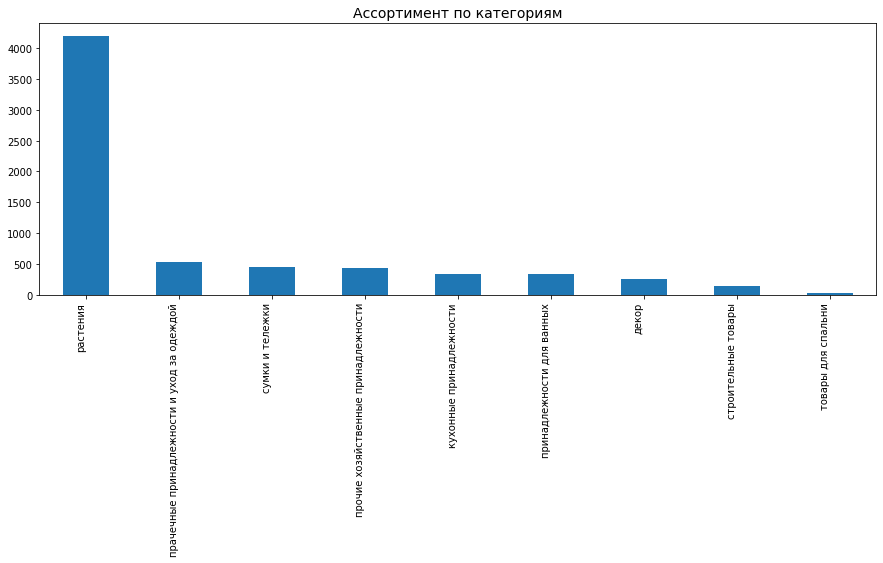

In [14]:
df['categories'].value_counts(ascending=False).plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.title('Ассортимент по категориям', fontsize = 14);

## 1.5. Оценка корректности объёма данных <a name="1-5"></a>

In [15]:
df['date'].agg([min, 'max'])

min   2018-10-01 00:00:00
max   2019-10-31 16:00:00
Name: date, dtype: datetime64[ns]

Здесь видно, что данные идут за год, но октябрь засчитан по двум годам 

In [16]:
df.query('date>="2019-10-01"').groupby('date')['revenue'].sum().sum() #октябрь 2019

250643.0

In [17]:
df.query('date<= "2018-10-31"').groupby('date')['revenue'].sum().sum() #октябрь 2018

410348.0

In [18]:
#удалим данные за октябрь 2018
df= df.query('date>"2018-11-01 00:00:00"')

In [19]:
df['date'].agg([min, 'max'])

min   2018-11-01 08:00:00
max   2019-10-31 16:00:00
Name: date, dtype: datetime64[ns]

# Выводы:
- Данные содержат 6,7 тыс.строк без пропущенных значений.
- Данным столбца product присущи категориальные признаки, следовательно необходомо осуществить преобразования. Для этого потребуется присвоение более крупных категорий всем sku в перечне.
- Типы данных соответствуют требованиям, за исключением столбца data: данные приведены в формат даты.
- В таблицу добавлен столбец с итоговой выручкой
- Пропуски и дубликаты отстутствуют.
- Для анализа были удалены данные за октябрь 2018, таким образом для анализа был взят ровно один год

 [Вернуться к оглавлению](#шаг-0)

# Шаг 2. Проведение исследовательского анализа данных (EDA) <a name="2"></a>

## 2.1. Оценка распределения данных - построение боксплотов, матриц рассеяния, построение распределений по датам, дням недели, времени суток <a name="2-1"></a>

In [20]:
df.describe()

,order_id,quantity,price,hour,week,dayofweek,month,year,revenue
count,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000
mean,41610.912480,2.397893,452.206321,13.900972,24.607942,2.720421,6.086386,2018.861426,718.075527
std,28020.345411,15.345421,875.043242,4.945619,12.844965,2.006422,2.961660,0.345529,8721.879974
min,12624.000000,1.000000,9.000000,0.000000,1.000000,0.000000,1.000000,2018.000000,9.000000
25%,14814.250000,1.000000,97.000000,10.000000,16.000000,1.000000,4.000000,2019.000000,120.000000
50%,14903.000000,1.000000,134.000000,14.000000,23.000000,3.000000,6.000000,2019.000000,150.000000
75%,70726.000000,1.000000,374.000000,18.000000,32.000000,4.000000,8.000000,2019.000000,590.000000
max,73164.000000,1000.000000,14917.000000,23.000000,52.000000,6.000000,12.000000,2019.000000,675000.000000


Описание данных позволяет сказать, что в  quantity, price и revenue присутствуют значительные выбросы - стандартные отклонения значительно превышают средние. 
Построим боксплоты:

*price*

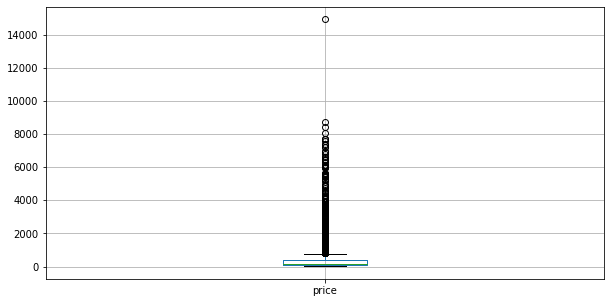

In [21]:
df.boxplot(column='price', figsize=(10, 5)) #проверим распределение данных по цене за единицу
plt.show()

In [22]:
df[df['price']>10000]

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,17,2019-07-29,31,0,7,2019,18:00-21:00,14917.0,сушилка уличный Leifheit 85210 LINOMATIC V 400...,прачечные принадлежности и уход за одеждой


Вероятно, закралась ошибка - указана завышенная стоимость. Удалим строку:

In [23]:
df = df.query('index != 5992')

*income*

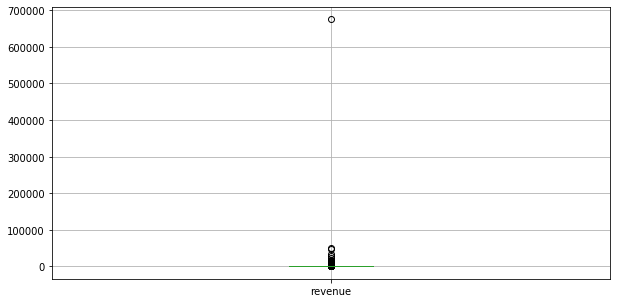

In [24]:
df.boxplot(column='revenue', figsize=(10, 5)) #проверим распределение данных по доходу
plt.show()

Есть аномалия, проверим:

In [25]:
df[df['revenue']>100000]

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,15,2019-06-18,25,1,6,2019,18:00-21:00,675000.0,"вантуз с деревянный ручка d14 см красный, Burs...",прочие хозяйственные принадлежности


In [26]:
df[df['customer_id']=='312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,15,2019-06-18,25,1,6,2019,18:00-21:00,675000.0,"вантуз с деревянный ручка d14 см красный, Burs...",прочие хозяйственные принадлежности


In [27]:
df[df['order_id']==71743]

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,15,2019-06-18,25,1,6,2019,18:00-21:00,675000.0,"вантуз с деревянный ручка d14 см красный, Burs...",прочие хозяйственные принадлежности


Была совершена разовая оптовая покупка, поэтому удаляем выброс:

In [28]:
df = df.query('index != 5456')

*quantity*

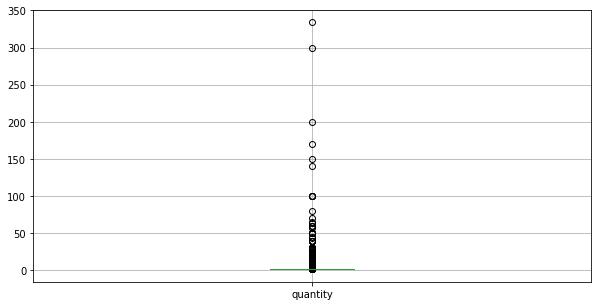

In [29]:
df.boxplot(column='quantity', figsize=(10, 5)) #проверим распределение данных по количеству единиц
plt.show()

In [30]:
df[df['quantity']>100]

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8,2018-11-01,44,3,11,2018,11:00-18:00,8670.0,муляж яблоко 9 см красный\n,декор
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,11,2018-11-02,44,4,11,2018,18:00-21:00,8260.0,муляж яблоко 9 см красный\n,декор
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,14,2018-12-10,50,0,12,2018,18:00-21:00,5800.0,"ручка-скоба РС-100 белый *трибатрон*, 1108035\n",прочие хозяйственные принадлежности
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,10,2019-03-23,12,5,3,2019,11:00-18:00,3000.0,плечики пластмассовый размер 52 - 54 тула 1205...,прачечные принадлежности и уход за одеждой
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,21,2019-05-20,21,0,5,2019,21:00-06:00,15300.0,муляж яблоко 9 см красный\n,декор
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,7,2019-06-11,24,1,6,2019,11:00-18:00,49432.0,вешалка мягкий для деликатный вещь 3 шт шоколад\n,прачечные принадлежности и уход за одеждой


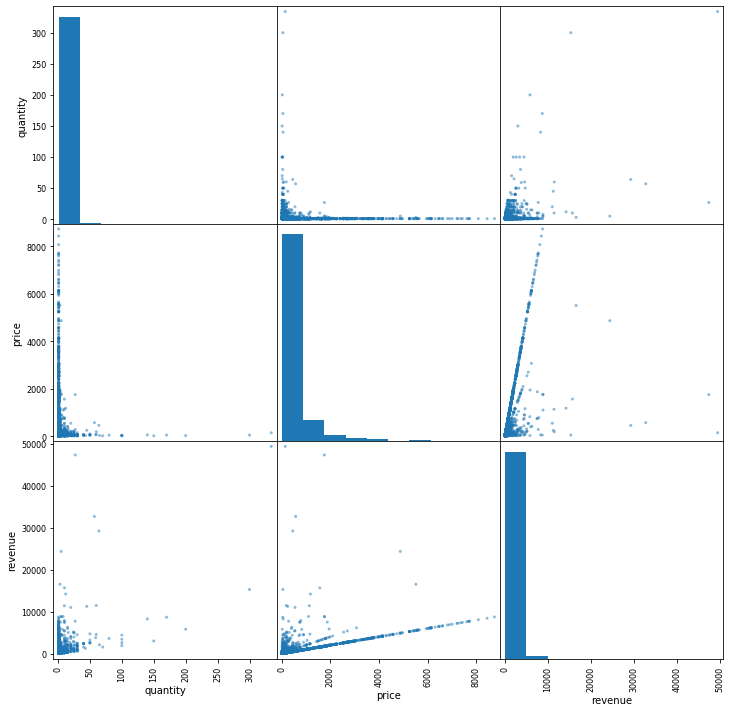

In [31]:
df1= df[['quantity', 'price', 'revenue']]
pd.plotting.scatter_matrix(df1, figsize=(12, 12)); #построим матрицу рассеяния

Матрица рассеяния позволяет увидеть следующее:

было продано большое количество недорогих товаров - большинство товаров до 500 за единицу;

товары одного наименования на один заказ приобретаются  в небольшом количестве - менее 5 единиц. 

In [32]:
df.head(2)

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories
567,2018-11-01 08:00:00,c9279020-09f8-461e-a694-4937485620d5,68816,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1,742.0,8,2018-11-01,44,3,11,2018,11:00-18:00,742.0,тележка багажный DELTA ТБР-20 синий грузоподъе...,сумки и тележки
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8,2018-11-01,44,3,11,2018,11:00-18:00,8670.0,муляж яблоко 9 см красный\n,декор


*распределения по датам*

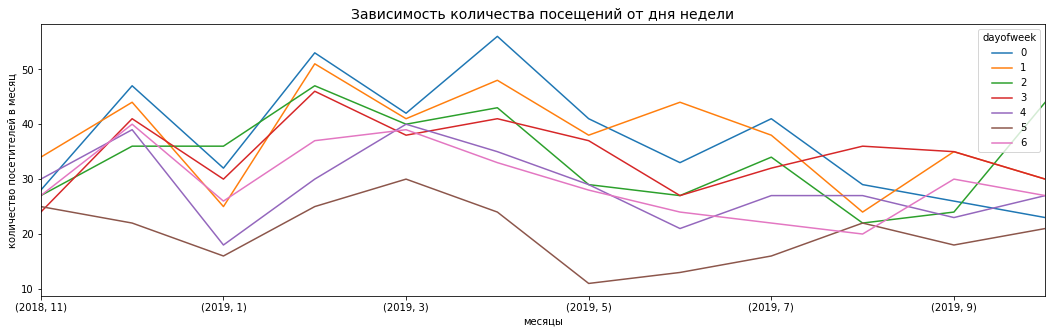

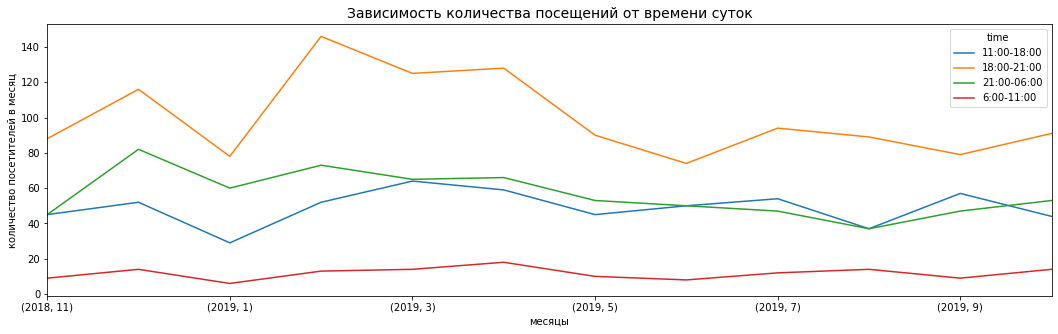

In [33]:
df.pivot_table(index=['year', 'month'], columns = 'dayofweek', values='customer_id',aggfunc='nunique').plot(figsize=(18,5))
plt.title('Зависимость количества посещений от дня недели', fontsize = 14)
plt.ylabel('количество посетителей в месяц')
plt.xlabel('месяцы')

df.pivot_table(index=['year', 'month'], columns = 'time', values='customer_id',aggfunc='nunique').plot(figsize=(18,5))
plt.title('Зависимость количества посещений от времени суток', fontsize = 14)
plt.ylabel('количество посетителей в месяц')
plt.xlabel('месяцы');

In [34]:
hours= df['hour'].reset_index()
hours['hour'].value_counts()

13    485
9     484
10    458
16    437
11    433
14    420
8     387
12    372
19    359
22    355
15    344
17    324
20    290
21    267
18    252
7     149
23     98
0      65
6      61
5      38
1      37
4      27
2      17
3       9
Name: hour, dtype: int64

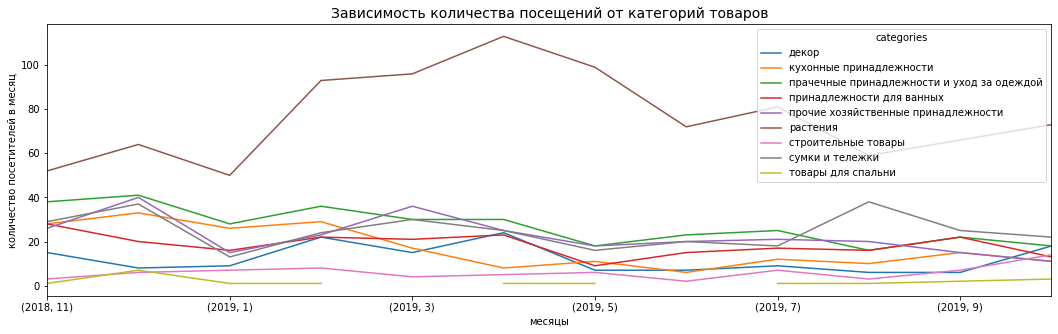

In [35]:
df.pivot_table(index=['year', 'month'], columns = 'categories', values='customer_id',aggfunc='nunique').plot(figsize=(18,5))
plt.title('Зависимость количества посещений от категорий товаров', fontsize = 14)
plt.ylabel('количество посетителей в месяц')
plt.xlabel('месяцы');

*Распределение по доходам*

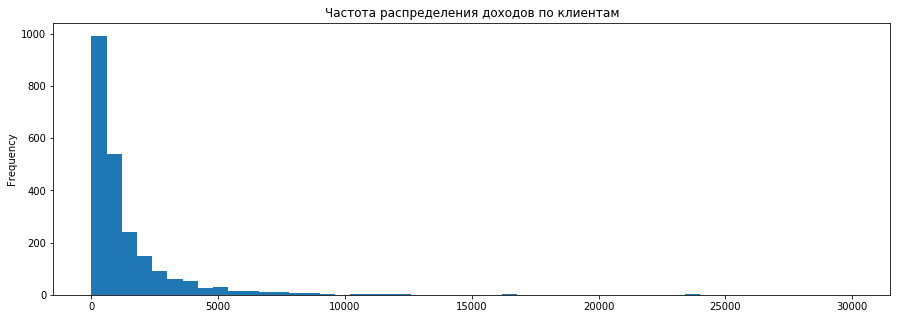

In [36]:
df.groupby('customer_id')['revenue'].sum().plot(kind = 'hist', range = (0,30000), bins = 50,  figsize = (15,5), title = 'Частота распределения доходов по клиентам');

Распределение продолжительности сессий нельзя отнести к нормальному, поэтому используем в расчёте не среднее, а моду -наиболее часто встречающееся значение:

In [37]:
s= df.groupby('customer_id').agg({'revenue':'sum'})
s['revenue'].mode()

0    134.0
dtype: float64

Таким образом  мы видим, что чаще всего клиенты оставляют в магазине сумму близкую к 134 рублям.

# Выводы:
Данные по количеству проданных sku, а также по цене за единицу товара и итоговой выручке показывают наличие большого превышения стандарных отклонений от средних величин, что свидетельствует о наличии выбросов в данных. Выбросы найдены и удалены (единичные случаи).

Магазин  (аналог магазинов OBI) реализует товары для дома и дачи и большую долю ассортимента составляют растения. 
Магазин реализует недорогие товары - большинство товаров до 500 за единицу и товары одного наименования на один заказ приобретаются  в небольшом количестве - менее 5 единиц. 

Влияние дня недели на количество посещений: для посещений клиенты выбирают чаще всего понедельник и вторник. Можно предположить, что  люди активно готовятся к поездкам на дачи в будние дни. В пятницу, субботу и воскресенье посетители магазина приходят не так активно.

Как показывает диаграмма зависимости посещений от времени суток, утренние часы не самые попялярные для покупок в магазине. Чаще всего магазин посещают в промежутке 18:00-21:00. 

Растения  - самая популярная категория товаров в магазине. Рост числа посещений с целью приобретения товаров в этой категории начинается в весенние месяцы, а пиковое время приходится на июнь.

Анализ распределения доходов по клиентам показывает, что клиенты оставляют в магазине сумму близкую к 134 рублям.

# Шаг 3. Определение потребительских сегментов   <a name="3"></a>

## 3.1. Сегментирование по дате покупки: когортный анализ по месяцам  <a name="3-1"></a>


## 3.2. Сегментирование по группам товаров <a name="3-2"></a>

In [38]:
groups_by_categories = df.groupby(['categories']).agg({'customer_id': 'nunique'}).reset_index()
groups_by_categories

,categories,customer_id
0,декор,143
1,кухонные принадлежности,200
2,прачечные принадлежности и уход за одеждой,314
3,принадлежности для ванных,217
4,прочие хозяйственные принадлежности,266
5,растения,885
6,строительные товары,69
7,сумки и тележки,281
8,товары для спальни,19


In [39]:
groups_by_categories['customer_id'].sum()

2394

''

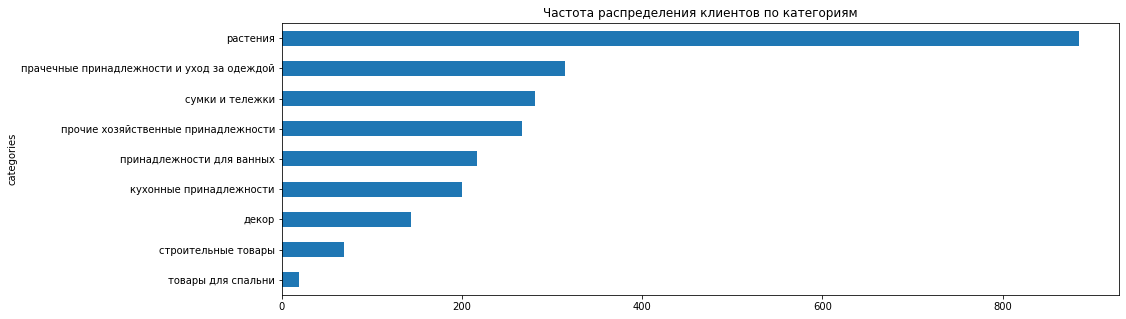

In [40]:
df.groupby('categories')['customer_id'].nunique().sort_values(ascending=True).plot(kind='barh', figsize = (15,5), title = 'Частота распределения клиентов по категориям')
;

Очевидно, что посетители магазина приходят преимущественно за различными растениями. 


##  3.3. Сегментирование по частоте покупок: расчёт DAU, WAU, MAU, sticky factor  <a name="3-3"></a>

In [41]:
df['customer_id'].nunique() #всего уникальных клиентов за исследуемый период


2273

In [42]:
df['order_id'].nunique() #всего заказов за исследуемый период

2545

In [43]:
#рассчитаем колличество уникальных покупателей за день, за неделю и за месяц:
dau = df.groupby('day').agg({'customer_id':'nunique'}).mean()
wau = df.groupby(['year', 'week']).agg({'customer_id':'nunique'}).mean()
mau = df.groupby(['year', 'month']).agg({'customer_id':'nunique'}).mean()

In [44]:
print('Кол-во уникальных посетителей магазина в день -  {}'.format(int(dau)))
print('Кол-во уникальных посетителей магазина в неделю  - {}'.format(int(wau)))
print('Кол-во уникальных посетителей магазина  в месяц  - {}'.format(int(mau)))      

Кол-во уникальных посетителей магазина в день -  7
Кол-во уникальных посетителей магазина в неделю  - 46
Кол-во уникальных посетителей магазина  в месяц  - 195


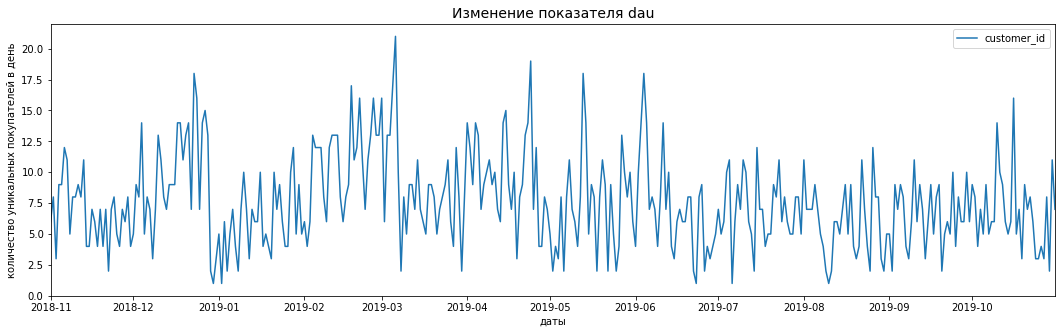

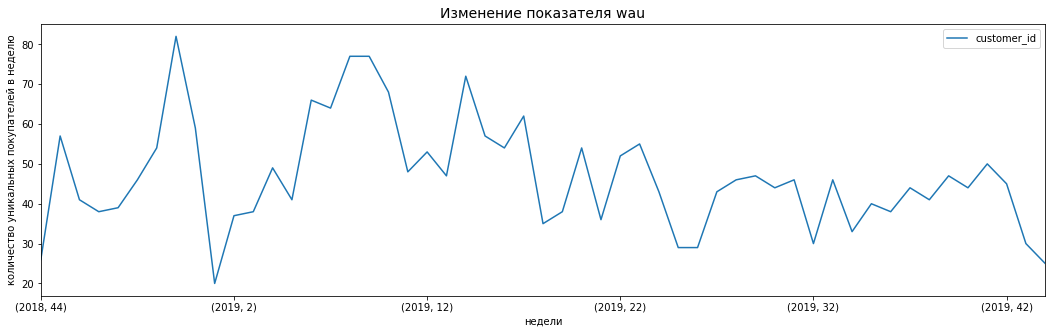

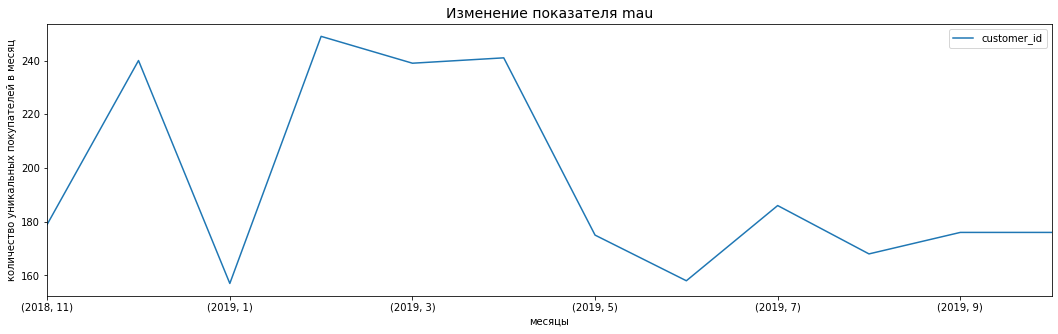

In [45]:
df.groupby('day').agg({'customer_id':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя dau', fontsize = 14)
plt.ylabel('количество уникальных покупателей в день')
plt.xlabel('даты')

df.groupby(['year', 'week']).agg({'customer_id':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя wau', fontsize = 14)
plt.ylabel('количество уникальных покупателей в неделю')
plt.xlabel('недели')

df.groupby(['year', 'month']).agg({'customer_id':'nunique'}).plot(figsize=(18,5))
plt.title('Изменение показателя mau', fontsize = 14)
plt.ylabel('количество уникальных покупателей в месяц')
plt.xlabel('месяцы');

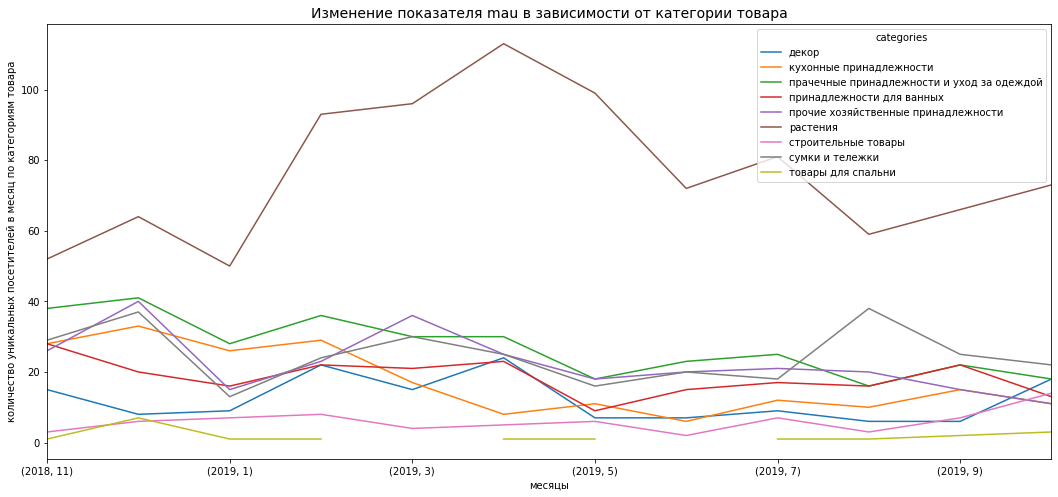

In [46]:
df.pivot_table(index=['year', 'month'], columns = 'categories', values='customer_id',aggfunc='nunique').plot(figsize=(18,8))
plt.title('Изменение показателя mau в зависимости от категории товара', fontsize = 14)
plt.ylabel('количество уникальных посетителей в месяц по категориям товара')
plt.xlabel('месяцы');

Новые посетители приходят в магазин за растениями: пик популярности категории приходится на весенние и летние месяцы. 

Расчитаем sticky factor.  Чем выше показатель, тем выше лояльность посетителей к магазину.

In [47]:
sticky_mau = (dau/mau)
sticky_wau = (dau/wau)

In [48]:
print('Недельная  лояльность аудитории: {:.2%}'.format(sticky_wau[0]))
print('Месячная  лояльность аудитории: {:.2%}'.format(sticky_mau[0]))

Недельная  лояльность аудитории: 16.31%
Месячная  лояльность аудитории: 3.91%


Лояльность аудитории невысока. Покупатели приходят в магазин чаще всего за сезонными товарами: весной приобретают рассаду и семена для дач и садовых участков, зимой в магазин приходят за товарами по уходу за одеждой и кухонными принадлежностями. В августе популярна категория сумки и тележки, вероятно, покупатели перемещают выращенный урожай со своих дач. 

## 3.4. Сегментирование по доходности клиента: сколько денег приносит каждый клиент (расчёт метрики LTV)<a name="3-4"></a>

In [49]:
df['buy_month'] = df['date'].astype('datetime64[M]')

#определим месяц первой покупки каждого покупателя:
first_buy = df.groupby('customer_id').agg({'buy_month': 'min'}).reset_index()
first_buy.columns = ['customer_id', 'first_buy_month']

#посчитаем количество новых покупателей (new_buyers) за каждый месяц:
cohort_sizes = first_buy.groupby('first_buy_month').agg({'customer_id': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'new_buyers']   

#построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу:
buy_new = pd.merge(df,first_buy, on='customer_id')

#cгруппируем таблицу  по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 
#cбросим индекс методом reset_index():
cohorts = buy_new.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()

#добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_buy_month')

#далее нужно найти валовую прибыль, умножив выручку на маржинальность. Здесь примем допущение, что маржинальность  равна 20%.
margin_rate = 0.2
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['buy_month'] - report['first_buy_month'])/ np.timedelta64(1, 'M') 
report['age'] = report['age'].round().astype('int')

#теперь найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. 
#для наглядности визуализируем когорты в виде сводной таблицы:
report['ltv'] = report['gp'] / report['new_buyers']
output = report.pivot_table(index='first_buy_month',columns='age', values='ltv', aggfunc='mean')
output.fillna('') 

#посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам:
ltv_2018_10 = output.loc['2018-11-01'].sum()
ltv_2018_10

542.3486033519553

В среднем каждый покупатель из первой когорты принес по 542 рубля выручки за 12 месяцев.

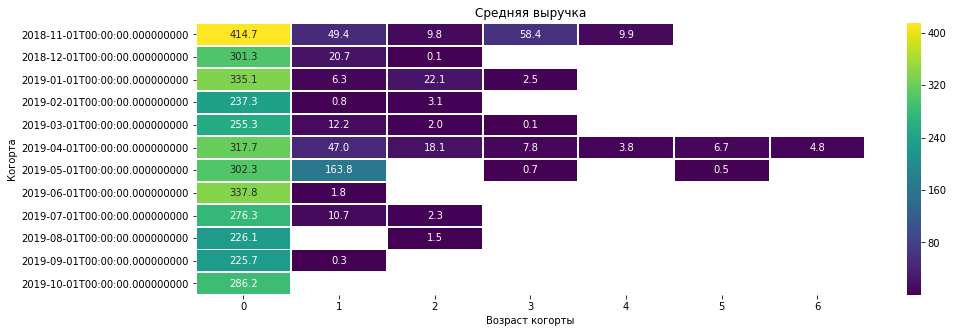

In [50]:
#построим тепловую карту для оценки средней выручки по клиентам:
    
plt.figure(figsize=(15, 5))
plt.title('Средняя выручка')
sns.heatmap(output, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Диаграмма показывает, что возраст когорт не превышает 6 месяцев. Наиболее "долгоживущая" когорта включает клиентов, пришедших в апреле 2019. Апрель - начало дачного  сезона.
Покупатели, попадая в магазин, тратят бОльшую сумму денег, чем в последующие посещения. Возможно, роль играет фактор спонтанных покупок. 

Первая когорта (11.2018) обеспечила максимальную среднюю выручку на покупателя в первый месяц: Активно приобретались товары для стирки, товары для кухни и различные сумки и тележки. Предположим, что средний чек по этим товарам достаточно высок и именно они отразились на величине средней выручки:

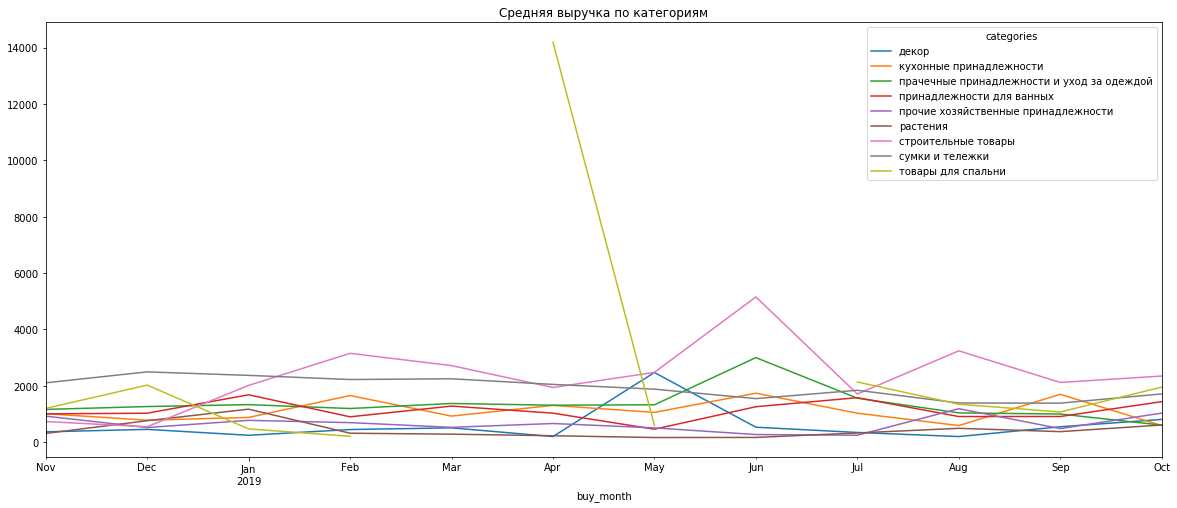

In [51]:
df.pivot_table(index='buy_month', columns='categories',values='revenue', aggfunc='mean').plot(figsize=(20, 8))
plt.title('Средняя выручка по категориям')
plt.ylim=([0, 1000])
plt.show();

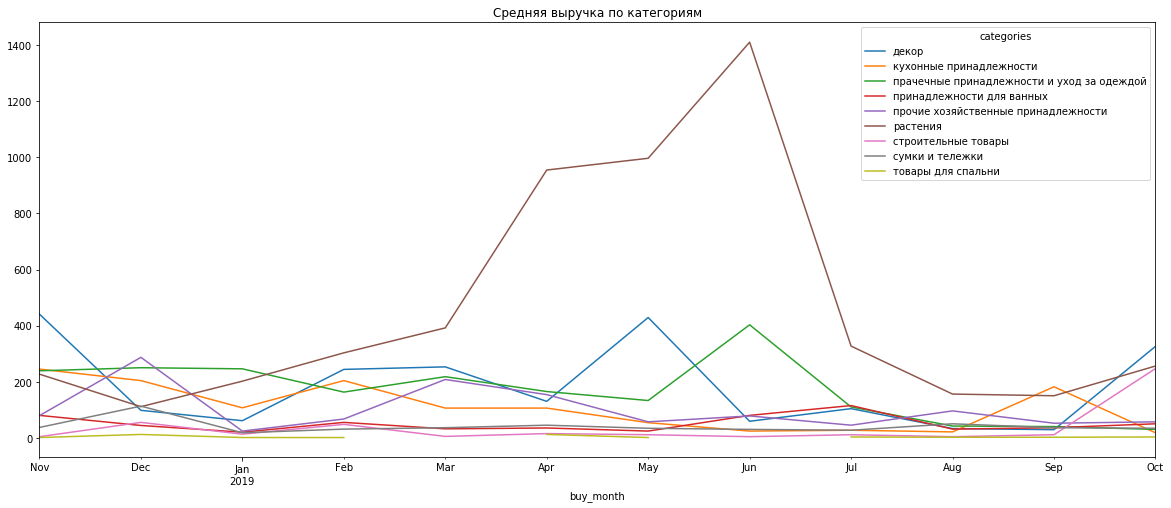

In [52]:
df.pivot_table(index='buy_month', columns='categories',values='quantity', aggfunc='sum').plot(figsize=(20, 8))
plt.title('Средняя выручка по категориям');

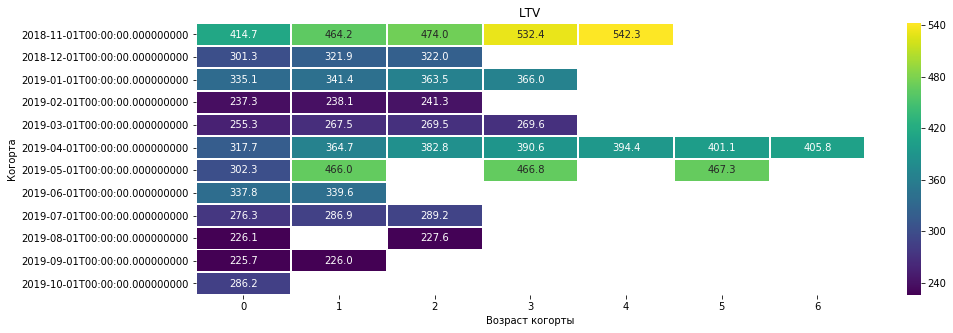

In [53]:
#и показатели LTV. Кумулятивный эффект на диаграмме позволяет оценить динамику:
ltv = output.cumsum(axis = 1)
plt.figure(figsize=(15, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show()

Очевидно, что первая когорта приносит наибольшую выручку. Довольно высокий показатель ltv для когорт, пришедших в мае и апреле (дачники). 


## 3.5. Сегментирование клиентов по величине среднего чека <a name="3-5"></a>


In [54]:
df = pd.merge(df,first_buy, on='customer_id') #здесь создадим новый столбец с первой покупкой
df.head(1)

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories,buy_month,first_buy_month
0,2018-11-01 08:00:00,c9279020-09f8-461e-a694-4937485620d5,68816,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1,742.0,8,2018-11-01,44,3,11,2018,11:00-18:00,742.0,тележка багажный DELTA ТБР-20 синий грузоподъе...,сумки и тележки,2018-11-01,2018-11-01


In [55]:
df['first_buy_month'] = df['first_buy_month'].astype('datetime64[M]')
df['buy_month'] = df['buy_month'].astype('datetime64[M]')

In [56]:
average_order_value = ((df['revenue'].mean()))  
print('Средний чек покупки одного товара равен {:.2f} руб.'.format(average_order_value))

Средний чек покупки одного товара равен 606.45 руб.


In [57]:
for_average_order_value = df.groupby('order_id')['revenue'].sum().reset_index()

In [58]:
print('Средний чек заказа равен {:.2f} руб.'.format(for_average_order_value['revenue'].mean()))

Средний чек заказа равен 1469.79 руб.


In [59]:
buy_cohorts = (df.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum', 'customer_id':'nunique'})).reset_index()
buy_cohorts['average_revenue'] = buy_cohorts['revenue'] / buy_cohorts['customer_id']

In [60]:
buy_cohorts['lifetime'] = ((buy_cohorts['buy_month'] -buy_cohorts['first_buy_month'])/np.timedelta64(1, 'M')).round().astype('int')
buy_cohorts['first_buy_month'] = buy_cohorts['first_buy_month'].dt.strftime('%Y-%m')

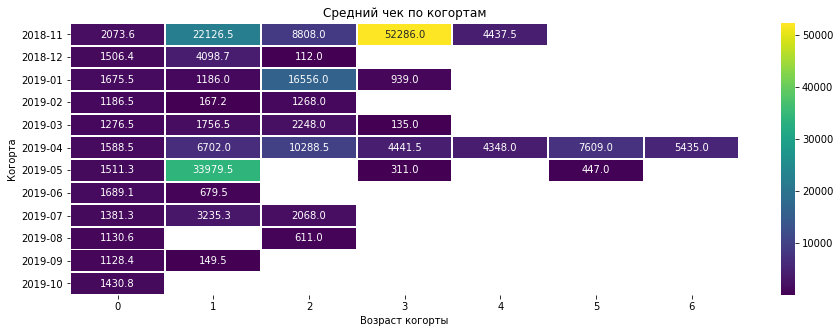

In [61]:
# Стоим тепловую карту 
average_revenue_pivot = (buy_cohorts.pivot_table(index='first_buy_month', columns='lifetime',values='average_revenue', aggfunc='mean'))
plt.figure(figsize=(15, 5))
plt.title('Средний чек по когортам')
sns.heatmap(average_revenue_pivot, annot=True, fmt='.1f', linewidths=1,  cmap = 'viridis')
plt.xlabel('Возраст когорты')
plt.ylabel('Когорта')
plt.show();

Тепловая карта показывает, что посетители  когорт  2018-11,  2019-04 и 2019-07 тратили на покупки суммы, превышающие средний чек (1470 руб.).  

Посетители из когорты 2019-01 потратили в  марте 2019 года суммы, значительно превышающие среднее. Также средний чек по когорте 2019-05 в июне превышает показатель  1470 руб.

# Выводы:
Кол-во уникальных посетителей магазина в день -  7
Кол-во уникальных посетителей магазина в неделю  - 46
Кол-во уникальных посетителей магазина  в месяц  - 195
Всего уникальных посетителей за исследуемый год - 2273

Новые посетители приходят в интернет-магазин преимущественноо за растениями: пик популярности категории приходится на весенние и летние месяцы. 

Лояльность аудитории (sticky factor) невысока. Покупатели приходят в магазин чаще всего за сезонными товарами: весной приобретают рассаду и семена для дач и садовых участков, зимой в магазин приходят за товарами по уходу за одеждой и кухонными принадлежностями. В августе популярна категория сумки и тележки, вероятно, покупатели перемещают выращенный урожай со своих дач.

Возраст когорт по средней выручке не превышает 6 месяцев. Наиболее "долгоживущая" когорта включает клиентов, пришедших в апреле 2019. Апрель - начало дачного сезона. Покупатели, попадая в магазин, тратят бОльшую сумму денег, чем в последующие посещения. Возможно, роль играет фактор спонтанных покупок.

Показатель LTV не превышает 550 рублей на клиента. Довольно высокий показатель ltv для когорт, пришедших в мае и апреле (дачники).

Средний чек одного заказа составляет 1470 рублей.

 [Вернуться к оглавлению](#шаг-0)

# Шаг 4. Статистический анализ <a name="4"></a>


## 4.2. Проверка гипотезы о том, что посетители магазина совершают покупки (по доходу) с одинаковой интенсивностью в зимний период  и летний периоды (оценка сезонности). <a name="4-2"></a>

Сформулируем гипотезу:

- H0 - нулевая гипотеза: средние выручки магазина в зимний и летний периоды **одинаковы**
- H1 - альтернативная гипотеза: средние выручки магазина в зимний и летний периоды **различаются**

Для проверки данных гипотез также расчитаем покзатель значение вероятности (p-value) с учетом заданного показателя критического уровня статистической значимости alpha. Пороговое значение альфа зададим в размере 5%. 

Если p-value окажется меньше alpha - отвергнем гипотезу.

Зимним периодом будем считать период с октября по март, соответственно, летний период  - с апреля по сентябрь:

In [62]:
#создаём новый столбец 
def season(month):
    if month in [10,11,12,1,2,3]:
        return 'зимний период'
    else:
        return 'летний период'
df['month_season'] = df['month'].apply(season)
df.sample(3)   

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,month,year,time,revenue,lemma_product,categories,buy_month,first_buy_month,month_season
5642,2019-08-26 21:00:00,f3577234-bbc8-4ecf-b1dd-df3d6517b936,72402,Сумка для тележки большая комбинированная 45*3...,1,374.0,21,2019-08-26,35,0,8,2019,21:00-06:00,374.0,сумка для тележка большой комбинированный 45*3...,сумки и тележки,2019-08-01,2019-08-01,летний период
3204,2019-05-13 14:00:00,76a4eb27-be99-4440-af5f-888a193cb802,14758,Рассада Арбуза сорт Шуга Бэби горшок 9х9 см P-9,2,38.0,14,2019-05-13,20,0,5,2019,18:00-21:00,76.0,рассада арбуз сорт шуга бэби горшок 9х9 см P-9\n,растения,2019-05-01,2019-05-01,летний период
90,2019-02-07 12:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70140,Контейнер для мусора ДОМИНИК CURVER 25 л сереб...,10,748.0,12,2019-02-07,6,3,2,2019,18:00-21:00,7480.0,контейнер для мусор доминик CURVER 25 л серебр...,кухонные принадлежности,2019-02-01,2018-11-01,зимний период


In [63]:
winter = df.query('month_season=="зимний период"').reset_index() 
summer = df.query('month_season=="летний период"').reset_index()

winter_revenue = winter['revenue']
summer_revenue = summer['revenue']

<font color=orange>проверяю нормальность данных с помощью критерия Шапиро-Уилка:</font>

In [64]:
results = st.shapiro(winter_revenue)
p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
alpha = .05 
print('p-значение: ', p_value)

if (p_value < alpha):
    print("распределение не нормально")
else:
    print("распределение нормально") 

p-значение:  0.0
распределение не нормально


In [65]:
results = st.shapiro(summer_revenue)
p_value = results[1]
alpha = .05 
print('p-значение: ', p_value)

if (p_value < alpha):
    print("распределение не нормально")
else:
    print("распределение нормально") 

p-значение:  0.0
распределение не нормально


<font color=orange>проверяю нормальность визуально c помощью простых гистограмм:</font>

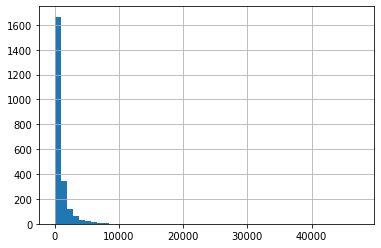

In [66]:
winter_revenue.hist(bins=50);

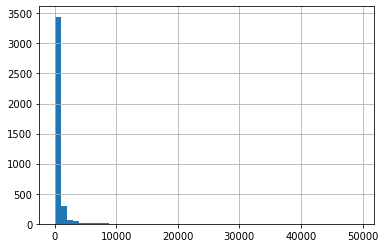

In [67]:
summer_revenue.hist(bins=50);

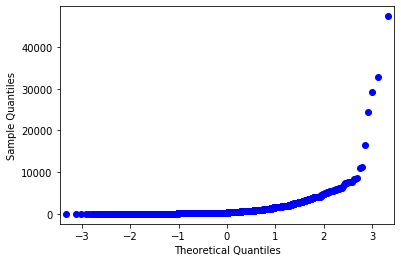

In [68]:
wintr = np.random.normal(winter_revenue)    
sm.qqplot(wintr)
py.show()

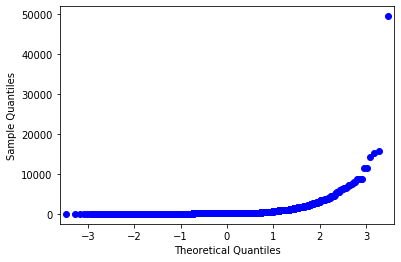

In [69]:
summr = np.random.normal(summer_revenue)    
sm.qqplot(summr)
py.show()

<font color=orange> Распределение ненормальное (большие выбросы на графиках qq), следовательно, использую не критерий Стьюдента, а  метод Манна-Уитни:</font>

In [70]:
alpha = 0.05 # критический уровень статистической значимости
results = st.mannwhitneyu(winter_revenue, summer_revenue)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 3.966018244489222e-94
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о равенстве средних выручек в зимний и летний периоды. Сезонность присутствует и по выручке зимние продажи превышают летние.

## 4.3. Проверка гипотезы от том, что в выходные и будние  дни посетители генерят  схожие средние чеки <a name="4-3"></a>

Сформулируем гипотезу:

- H0 - нулевая гипотеза: средние чеки магазина в выходные и будни **одинаковы**
- H1 - альтернативная гипотеза: средние вчеки магазина в выходные и будни **различаются**

Пороговое значение альфа зададим в размере 5%. 

Если p-value окажется меньше alpha - отвергнем гипотезу.

In [71]:
#создаём новый столбец 
def w_end(w_day):
    if w_day in [5,6]:
        return 'выходные дни'
    else:
        return 'будние дни'
df['weekend'] = df['dayofweek'].apply(w_end)

In [72]:
weekend = df.query('weekend=="выходные дни"').reset_index() 
weekdays = df.query('weekend=="будние дни"').reset_index()

weekend['av_rev'] = weekend['revenue'].mean()
weekdays['av_rev'] = weekdays['revenue'].mean()

weekend_average_revenue = weekend['av_rev']
weekdays_average_revenue = weekdays['av_rev']

<font color=orange> и снова всё проверяю, но уже без гистограмм и проверки с помощью критерия Шапиро:</font>

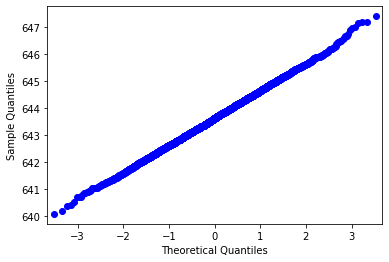

In [73]:
wkdays = np.random.normal(weekdays_average_revenue)    
sm.qqplot(wkdays)
py.show()

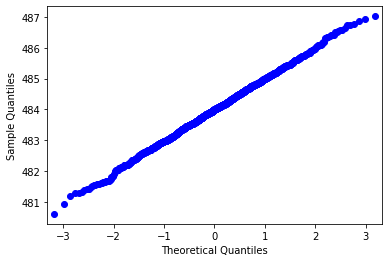

In [74]:
wkend = np.random.normal(weekend_average_revenue)    
sm.qqplot(wkend)
py.show()

<font color=orange> Распределение нормально, соответственно, я могу использовать критерий стьюдента</font>

In [75]:
alpha = 0.05 # критический уровень статистической значимости
results = st.ttest_ind(weekend_average_revenue, weekdays_average_revenue)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что средние чеки магазина в выходные и будни одинаковы: в будни средний чек выше 

## 4.4. Проверка гипотезы от том, что в вечерние и дневные часы посетители приносят магазину одинаковую выручку <a name="4-4"></a>

Сформулируем гипотезу:

H0 - нулевая гипотеза: выручки  магазина в дневные и ночные часы **одинаковы**

H1 - альтернативная гипотеза: выручки  магазина в дневные и ночные часы **различаются**

Пороговое значение альфа зададим в размере 5%.

Если p-value окажется меньше alpha - отвергнем гипотезу.

In [76]:
df['time'].value_counts()

18:00-21:00    2815
21:00-06:00    1621
11:00-18:00    1478
6:00-11:00      254
Name: time, dtype: int64

In [77]:
eve = df.query('time=="18:00-21:00" or time =="21:00-06:00"').reset_index() 
day = df.query('time=="06:00-11:00" or  time =="11:00-18:00"').reset_index()

eve_revenue = eve['revenue']
day_revenue = day['revenue']

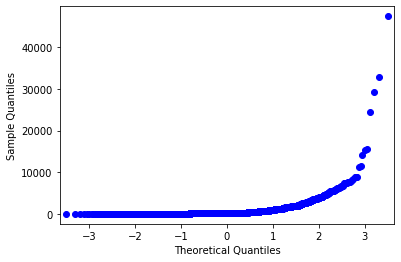

In [78]:
everev = np.random.normal(eve_revenue)    
sm.qqplot(everev)
py.show()

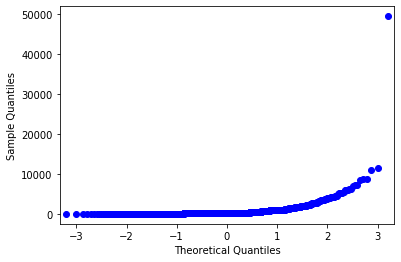

In [79]:
dayrev = np.random.normal(day_revenue)    
sm.qqplot(dayrev)
py.show()

<font color=orange> Распределение Ненормально, соответственно, испрользую метод Манна_Уитни: </font>

In [80]:
alpha = 0.05

results = st.mannwhitneyu(eve_revenue, day_revenue)

print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.13230900229963566
Не получилось отвергнуть нулевую гипотезу


Не удалось отвергнуть нулевую гипотезу о равенстве выручки в дневное и вечернее время. 

## 4.5. Проверка гипотезы о различиях средней частоты заказов в различных сегментах покупателей<a name="4-5"></a>

проверим гипотезу о различиях средней частоты заказов в сегментах  покупателей с различным средним чеком:

In [81]:
df1 = (df.groupby(['customer_id']).agg({'order_id':'nunique', 'revenue':'sum', 'quantity':'sum'}).reset_index())
df1['avg_check'] = df1['revenue'] / df1['order_id']

df1.head(10)

,customer_id,order_id,revenue,quantity,avg_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,555.0,4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,914.0,2,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,2324.0,2,2324.0
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,1,1536.0,12,1536.0
6,00c0f92a-121a-4883-a78d-2c7b5fe187de,1,134.0,1,134.0
7,00c95d20-923e-4b45-88fc-53b12931d462,1,959.0,1,959.0
8,00cd704a-a65c-4865-b39a-779f1b4f1d1a,1,112.0,1,112.0
9,00e59a12-06d5-47fc-9a33-bfc53aca1e9f,1,1798.0,2,1798.0


In [82]:
#поделить на сегменты можно с помощью описательной статитстики:
df1['avg_check'].describe() 

count      2273.000000
mean       1469.309941
std        3745.723390
min          14.000000
25%         299.000000
50%         712.000000
75%        1574.000000
max      114750.000000
Name: avg_check, dtype: float64

In [83]:
from_0_to_700 =df1.query('avg_check  <700').reset_index()
more_700 =df1.query('avg_check >=700').reset_index() 

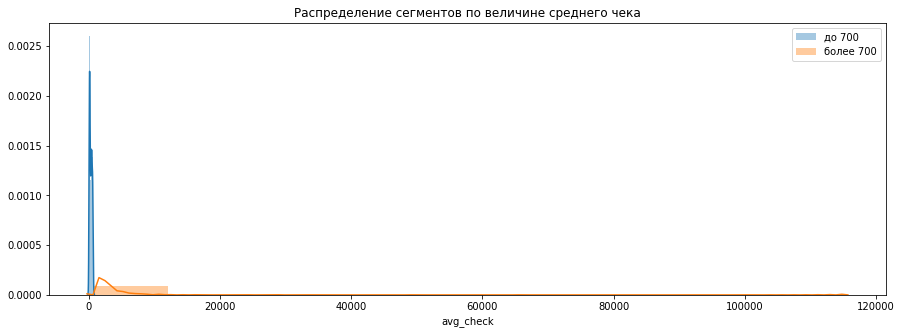

In [84]:
plt.figure(figsize=(15, 5))
sns.distplot(from_0_to_700['avg_check'], bins = 10)
sns.distplot(more_700['avg_check'], bins = 10)
plt.legend(['до 700','более 700'])
plt.title('Распределение сегментов по величине среднего чека')
plt.show()

Из диаграммы видно, что доли сегментов по численности различны: доля клиентов со средним чеком до 700 рублей наиболее значительна. 
Проверим, равнозначны ли сегменты по общей выручке.
Формируем гипотезы:

H0 - нулевая гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей **одинаковы**

H1 - альтернативная гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей **различаются**


In [85]:
_0_700_revenue = from_0_to_700['revenue']
more_700_revenue = more_700['revenue']

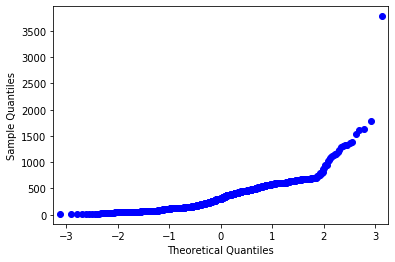

In [86]:
less_700 = np.random.normal(_0_700_revenue)    
sm.qqplot(less_700)
py.show()

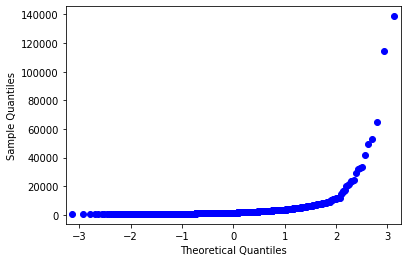

In [87]:
more_700 = np.random.normal(more_700_revenue)    
sm.qqplot(more_700)
py.show()

<font color=orange> Распределение Ненормально, соответственно, испрользую метод Манна_Уитни: </font>

In [88]:
alpha = 0.05
results = st.mannwhitneyu(_0_700_revenue, more_700_revenue)
print('p-значение:', results.pvalue) 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу о том, что выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей одинаковы.  Несмотря на то, что сегмент со средним чеком менее 700  рублей количественно значительно превышает по численности сегмент со средним чеком свыше 700 р, наибольшую выручку магазину приносят именно клиенты с высоким средним чеком. 

# Выводы:

Были проверены следующие нулевые и альнернативные гипотезы:

1) H0 - нулевая гипотеза: средние выручки магазина в зимний и летний периоды одинаковы
   H1 - альтернативная гипотеза: средние выручки магазина в зимний и летний периоды различаются

   Нулевая гипотеза была отвергнута: сезонность присутствует и по выручке зимние продажи превышают летние.

2) H0 - нулевая гипотеза: средние чеки магазина в выходные и будни одинаковы
   H1 - альтернативная гипотеза: средние вчеки магазина в выходные и будни различаются
   
   Нулевая гипотеза была отвергнута: средние чеки  в выходные дни ниже, чем в будние. Это выглядит логично, т.к. целевая аудитория проводит выходные за городом. 

3) H0 - нулевая гипотеза: выручки  магазина в дневные и ночные часы одинаковы
   H1 - альтернативная гипотеза: выручки  магазина в дневные и ночные часы различаются
   
   Не удалось отвергнуть нулевую гипотезу: выручки в вечернее и дневное  время практически одинакова 
   
   
Также была проверена гипотеза о  различиях средней частоты заказов в сегментах  покупателей с различным средним чеком:

Доли сегментов по численности различны: доля клиентов со средним чеком до 700 рублей наиболее значительна. 
Проверим, равнозначны ли сегменты по общей выручке. Таким образом была была проверена гипотеза о  различиях средней частоты заказов в сегментах  покупателей с различным средним чеком:

H0 - нулевая гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей одинаковы
H1 - альтернативная гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей различаются

Нулевая гипотеза была отвергнута: несмотря на то, что сегмент со средним чеком менее 700  рублей количественно значительно превышает по численности сегмент со средним чеком свыше 700 р, наибольшую выручку магазину приносят именно клиенты с высоким средним чеком.

## Кластеризация <a name="4-6"></a>

In [89]:
#стандартизируем данные

def categories_class(categories):
    if  categories== 'растения':
        return 1
    if  categories== 'прачечные принадлежности и уход за одеждой':
        return 2
    if  categories== 'сумки и тележки':
        return 3
    if  categories== 'прочие хозяйственные принадлежности':
        return 4
    if  categories== 'кухонные принадлежности':
        return 5
    if  categories== 'принадлежности для ванных':
        return 6
    if  categories== 'декор':
        return 7
    if  categories== 'строительные товары':
        return 8
    else:
        return 9
df['categories_class'] = df['categories'].apply(categories_class)

In [90]:
df.head(1)

,date,customer_id,order_id,product,quantity,price,hour,day,week,dayofweek,...,year,time,revenue,lemma_product,categories,buy_month,first_buy_month,month_season,weekend,categories_class
0,2018-11-01 08:00:00,c9279020-09f8-461e-a694-4937485620d5,68816,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1,742.0,8,2018-11-01,44,3,...,2018,11:00-18:00,742.0,тележка багажный DELTA ТБР-20 синий грузоподъе...,сумки и тележки,2018-11-01,2018-11-01,зимний период,будние дни,3


In [91]:
#агрегируем по покупателям:
df1 = df.groupby('customer_id').agg({'quantity': 'mean', 'price': 'mean', 'hour': 'mean', 'dayofweek': 'mean', 'month': 'mean', 'revenue': 'sum', 'categories_class': 'mean'}).reset_index()

In [92]:
X =df1[['quantity', 'price','dayofweek', 'month', 'revenue']]

In [93]:
#сделаем проверку по сумме:
X['revenue'].sum()-df['revenue'].sum()

0.0

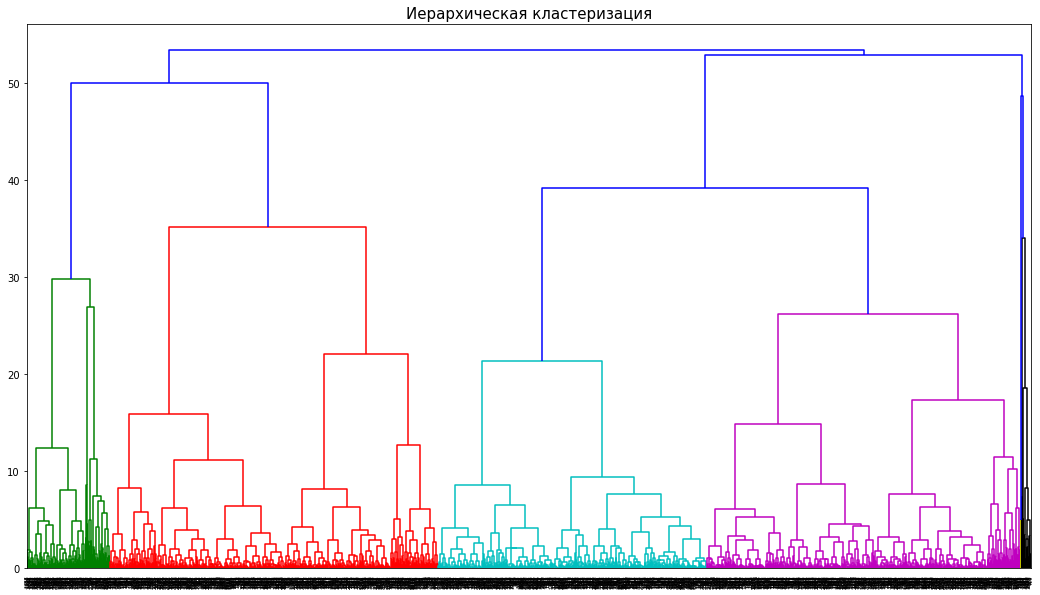

In [94]:
#стандартизируем данные:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков:
linked = linkage(X_sc, method='ward') 

#рисуем дендрограмму:
plt.figure(figsize=(18,10))
dendrogram(linked, orientation='top')
plt.title("Иерархическая кластеризация", fontsize = 15)
plt.show()

#обучаем модель кластеризации на основании алгоритма K-Means, задаём число кластеров=3:
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(X_sc)

#создаём новый столбец для агрегированных данных
df1['cluster'] = labels

In [95]:
#посчитаем метрику силуэта для оценки качества кластеризации:
silhouette = silhouette_score(X_sc, labels)
silhouette

0.2665189686055383

Значение метрики силуэта 0,27. Чем ближе к 1, тем качественнее кластеризация. Показатель не самый высокий - объект  сопоставляется с собственным кластером, но есть перекрывания с соседними кластерами.

In [96]:
#считаем для каждого полученного кластера доли:
clusters = df1.groupby('cluster').mean().round(decimals=2)
clusters = np.transpose(clusters) 
display(clusters)

cluster,0,1,2
quantity,2.90,2.40,111.95
price,559.99,1008.91,365.69
hour,14.04,13.68,12.66
dayofweek,2.53,2.96,1.92
month,3.61,9.66,7.39
revenue,1219.75,1636.39,34333.19
categories_class,2.92,3.24,4.01


Описание кластеров:

0 - Представители этого кластера покупают в среднем 2,9 единиц товаров. Средняя цена на единицу покупаемой продукции - (560 руб). Кластер генерит минимальную по трем кластерам  выручку, ниже показателя среднего чека. Основные месяцы посещения - март и апрель,  основное время посещения - днём приблизительно в 14:00. Основной приобретаемый товар - 'сумки и тележки'. Популярные дни для посещения - среда и четверг.

1 - Представители кластера приобретают в магазине в среднем более 2,4 единицы товаров по средней стоимости в размере 1000 рублей. Основное время посещения - днём до 14:00, популярный день для посещения - четверг, месяцы посещений - сентябрь и октябрь. Средняя выручка на клиента- более 1600 рублей. Основной приобретаемый товар -  'сумки и тележки'.

2 - Самый доходный кластер, но и количество единиц товаров здесь тоже выше. Приобретают недорогие товары. Вероятно,это оптовые покупатели и/или юридические лица. Представители кластера приходят чаще всего летом (июль), основное время посещения -  после полудня.  Основной приобретаемый товар - 'прочие хозяйственные принадлежности'. Популярные дни для посещения - среда.

Все кластеры характеризуются основным временем покупок в районе 13-14 часов в среду и четверг. Можно предположить, что основная доля заказчиков  работает в офисе  и совершает покупки в обеденный перерыв, рассчитывая, что заказанный в середине недели товар, будет доставлен к выходным, которые у пользователей посвящены поездкам на дачи.

<font color=orange>  Возможно, классы по категориям включать не следует - рискуем получить искажённый средний результат: получаем 3 (сумки и тележки), а на самом деле покупали 1 и 6 </font>

In [97]:
# проверка 
m = pd.DataFrame(df1.groupby('customer_id')['cluster'].nunique())
m[m['cluster'] > 1]

,cluster
customer_id,


In [98]:
# проверка
df1[df1['customer_id'] == '028469c0-9e87-4596-ac2e-c5b1d48ea9b6']

,customer_id,quantity,price,hour,dayofweek,month,revenue,categories_class,cluster
28,028469c0-9e87-4596-ac2e-c5b1d48ea9b6,30.0,26.0,17.333333,2.0,8.333333,2340.0,2.0,1


 [Вернуться к оглавлению](#шаг-0)

# Шаг 5. Результаты <a name="5"></a>

##  5.1. Основные выводы <a name="5-1"></a>

Для товаров были созданы товарные категории: всего 9 категорий.
Анализ позволяет сделать вывод о формате магазина: это аналог OBI, в ассортименте которого основная доля принадлежит товарам для дачи и сада. Основная категория товара - растения (рассада, цветы, семена). 

Магазин продаёт большое количество недорогой продукции   - большинство товаров до 500 р. за единицу при этом товары одного наименования на один заказ приобретаются в небольшом количестве - менее 5 единиц.


Можем предположить, что основная целевая аудитория магазина - это владельцы дач и садовых участков, любителели активного отдыха и пикников. 

Влияние дня недели на посещения проявляется в период с мая по июнь  - в этот период понедельние и вторник являются наиболее популярными для посещения днями. Можно предположить, что в эти месяцы люди активно отправляются в отпуск и готовятся к поездкам на дачи, а отпуск, как правило, страртует с понедельника. 

Как показывает диаграмма зависимости посещений от времени суток, утренние часы не самые попялярные для покупок в магазине. 

Растения  - самая популярная категория товаров в магазине. Рост числа посещений с целью приобретения товаров в этой категории начинается в весенние месяцы, а пиковое время приходится на июнь.

Анализ распределения доходов по клиентам показывает, что клиенты оставляют в магазине сумму близкую к 134 рублям.

Кол-во уникальных посетителей магазина в день -  7
Кол-во уникальных посетителей магазина в неделю  - 46
Кол-во уникальных посетителей магазина  в месяц  - 195
Всего уникальных посетителей за исследуемый год - 2273

Новые посетители приходят в интернет-магазин преимущественноо за растениями: пик популярности категории приходится на весенние и летние месяцы. 

Лояльность аудитории (sticky factor) невысока. Покупатели приходят в магазин чаще всего за сезонными товарами: весной приобретают рассаду и семена для дач и садовых участков, зимой в магазин приходят за товарами по уходу за одеждой и кухонными принадлежностями. В августе популярна категория сумки и тележки, вероятно, покупатели перемещают выращенный урожай со своих дач.

Возраст когорт по средней выручке не превышает 6 месяцев. Наиболее "долгоживущая" когорта включает клиентов, пришедших в апреле 2019. Апрель - начало дачного сезона. Покупатели, попадая в магазин, тратят бОльшую сумму денег, чем в последующие посещения. Возможно, роль играет фактор спонтанных покупок.

Показатель LTV не превышает 550 рублей на клиента. Довольно высокий показатель ltv для когорт, пришедших в мае и апреле (дачники).

Были проверены следующие нулевые и альнернативные гипотезы:

1) H0 - нулевая гипотеза: средние выручки магазина в зимний и летний периоды одинаковы
   H1 - альтернативная гипотеза: средние выручки магазина в зимний и летний периоды различаются

   Нулевая гипотеза была отвергнута: сезонность присутствует и по выручке зимние продажи превышают летние.

2) H0 - нулевая гипотеза: средние чеки магазина в выходные и будни одинаковы
   H1 - альтернативная гипотеза: средние чеки магазина в выходные и будни различаются
   
   Нулевая гипотеза была отвергнута: средние чеки  в выходные дни ниже, чем в будние. Это выглядит логично, т.к. целевая аудитория проводит выходные за городом. 

3) H0 - нулевая гипотеза: выручки  магазина в дневные и ночные часы одинаковы
   H1 - альтернативная гипотеза: выручки  магазина в дневные и ночные часы различаются
   
   Не удалось отвергнуть нулевую гипотезу: выручки в вечернее и дневное  время практически одинаковы
   
   
Также была проверена гипотеза о  различиях средней частоты заказов в сегментах  покупателей с различным средним чеком:

Доли сегментов по численности различны: доля клиентов со средним чеком до 700 рублей наиболее значительна. 
Проверим, равнозначны ли сегменты по общей выручке. Таким образом была была проверена гипотеза о  различиях средней частоты заказов в сегментах  покупателей с различным средним чеком:

    H0 - нулевая гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей одинаковы
    H1 - альтернативная гипотеза: выручки сегмента со средним чеком до 700 рублей и сегмента со средним чеком более 700 рублей различаются

Нулевая гипотеза была отвергнута: несмотря на то, что сегмент со средним чеком менее 700  рублей количественно значительно превышает по численности сегмент со средним чеком свыше 700 р, наибольшую выручку магазину приносят именно клиенты с высоким средним чеком.

Таким образом былы получены следующие сегменты покупателей:

Совершающие недорогие заказы (стоимостью до 700 руб.) и  более дорогие заказы (стоимостью более 700 руб.)
Совершающие покупки преимущественно  в выходные и совершающие покупки в будни.
Покупатели, которые чаще посещают магазин в зимнее время и покупатели, посещающие магазин летом.


##  5.2. Рекомендации <a name="5-2"></a>

Поскольку лояльность невысока и  клиенты редко возвращаются в магазин повторно (по крайней мере в течение года), следует работать над повышением лояльности:
необходимо проанализировать программы лояльности, если они существуют, и разработать ряд стимулирующих мероприятий, например, начислять выгодные бонусы, если клиент вернулся в магазин в течение недели.

Необходимо создавать  мероприятия для увеличения среднего чека   в сегменте со средним чеком мене 700 руб. В качестве стимулирующих мероприятий предлагается также использовать бонусную систему. 

Для сегмента клиентов, предпочитающих совершать покупки в выходные  дни  необходимо рассылать уведомления в четверг и пятницу. Это позволит не только напомнить клиентам о своем существовании, но также, возможно, увеличить выручку по сегменту, предпочитающему  покупки в субботу и воскресенье.

 [Вернуться к оглавлению](#шаг-0)

In [99]:
dash1=df[['date', 'day', 'quantity', 'revenue', 'order_id', 'customer_id','categories']]

In [100]:
dash1.to_csv('dash1.csv', index = False)